C:\Users\gifta\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\gifta\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_core.py:1485: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


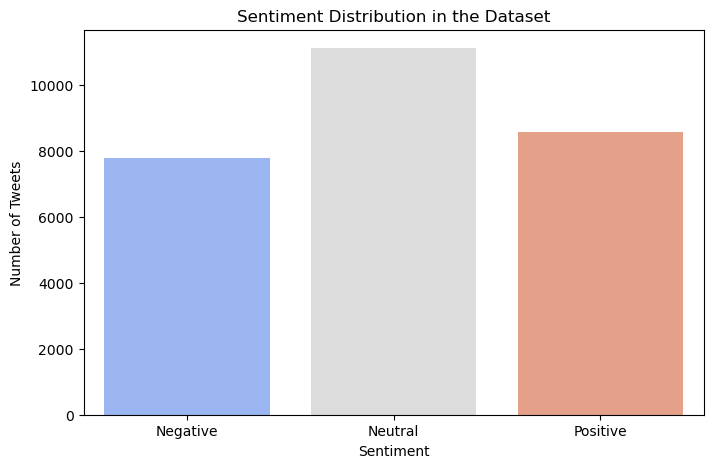

,textID,text,selected_text,sentiment,clean_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",1,id have responded if i were going
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,0,sooo sad i will miss you here in san diego
2,088c60f138,my boss is bullying me...,bullying me,0,my boss is bullying me
3,9642c003ef,what interview! leave me alone,leave me alone,0,what interview leave me alone
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",0,sons of why couldnt they put them on the relea...


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

# Load the dataset
file_path ="Tweets.csv"
df = pd.read_csv(file_path, encoding="latin1")

# Remove missing values, in this case by dropping rows where the 'text' column is empty
df.dropna(subset=["text"], inplace=True)

# Converting sentiment labels to numerical values; this makes it easier for the models to process the data
sentiment_mapping = {"negative": 0, "neutral": 1, "positive": 2}
df["sentiment"] = df["sentiment"].map(sentiment_mapping)

# Clean text
def clean_tweet(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r"http\S+|www\S+", "", text)  # Remove URLs
    text = re.sub(r"@\w+", "", text)  # Remove mentions (@)
    text = re.sub(r"[^a-zA-Z0-9\s]", "", text)  # Remove special characters
    text = re.sub(r"\s+", " ", text).strip()  # Remove extra spaces
    return text

# Applying text cleaning function
df["clean_text"] = df["text"].apply(clean_tweet)

# Count the number of tweets per sentiment category
sentiment_counts = df["sentiment"].value_counts().sort_index()

# Map sentiment labels back for visualisation
sentiment_labels = ["Negative", "Neutral", "Positive"]

# Plot the sentiment distribution
plt.figure(figsize=(8,5))
sns.barplot(x=sentiment_labels, y=sentiment_counts.values, palette="coolwarm")
plt.xlabel("Sentiment")
plt.ylabel("Number of Tweets")
plt.title("Sentiment Distribution in the Dataset")
plt.show()

df.head()

In [2]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

# Initialize TF-IDF Vectorizer which helps convert text into numerical values based on word importance
tfidf_vectorizer = TfidfVectorizer(max_features=5000)  # Limit to 5000 most important words

# Convert text data into TF-IDF numerical representation 
X = tfidf_vectorizer.fit_transform(df["clean_text"])
y = df["sentiment"]  # Defining target variable

# # The dataset is split in 80% train and 20% test to ensure enough data for training while reserving unseen data for evaluation.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display dataset shape after transformation
X_train.shape, X_test.shape


((21984, 5000), (5496, 5000))

In [3]:
# Importing libraries for the models
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score


# Train Naive Bayes Model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)
nb_predictions = nb_model.predict(X_test)

# Train Logistic Regression Model
lr_model = LogisticRegression(max_iter=200)
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)

# Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Function to calculate and display evaluation metrics
def evaluate_model(name, y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    
# Evaluate each model
evaluate_model("Naïve Bayes", y_test, nb_predictions)
evaluate_model("Logistic Regression", y_test, lr_predictions)
evaluate_model("Random Forest", y_test, rf_predictions)



Precision  Recall  F1-Score  Accuracy
Naïve Bayes         Negative      0.743   0.463     0.571     0.639
                    Neutral       0.558   0.799     0.657     0.639
                    Positive      0.759   0.592     0.665     0.639
Logistic Regression Negative      0.704   0.578     0.635     0.684
                    Neutral       0.619   0.744     0.676     0.684
                    Positive      0.781   0.703     0.740     0.684
Random Forest       Negative      0.718   0.522     0.605     0.683
                    Neutral       0.617   0.765     0.683     0.683
                    Positive      0.773   0.725     0.748     0.683

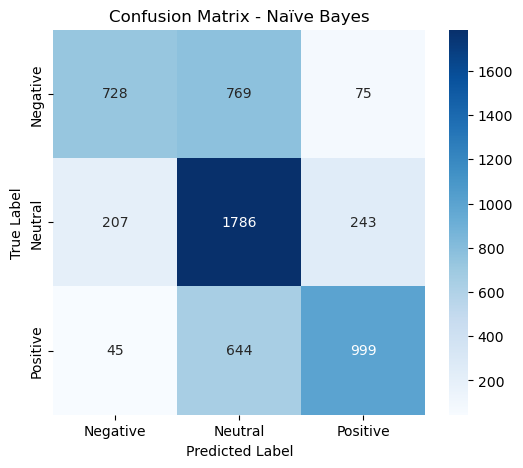

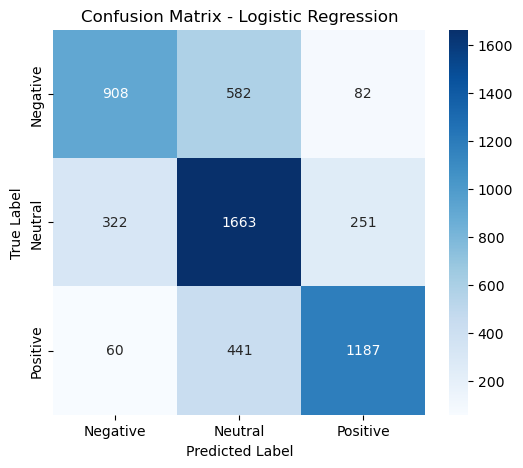

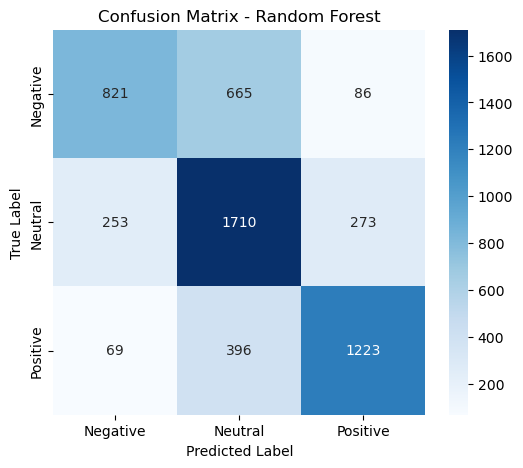

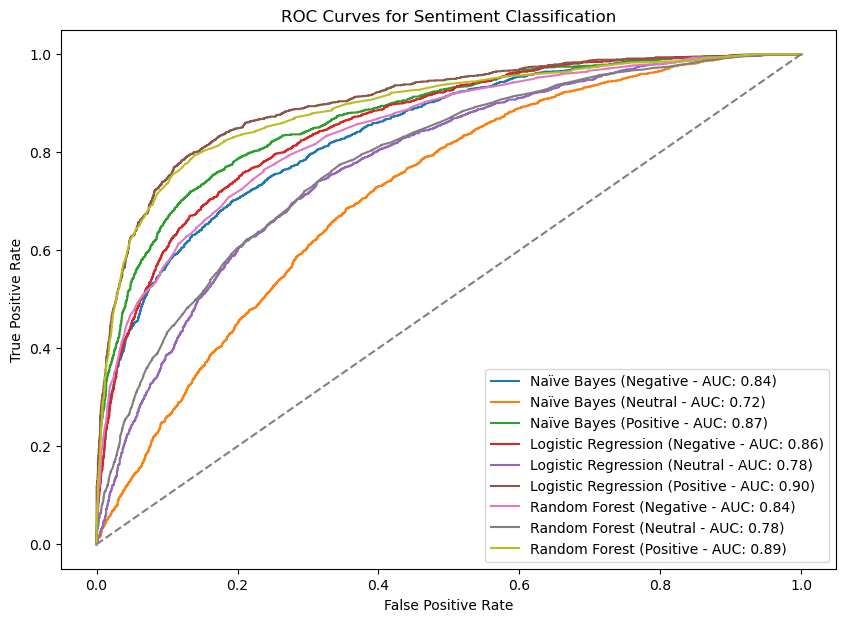

In [4]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

# Generate classification reports for each model
models = {
    "Naïve Bayes": nb_predictions,
    "Logistic Regression": lr_predictions,
    "Random Forest": rf_predictions,
}

# Collect classification reports in a dictionary
classification_reports = {}
for model_name, predictions in models.items():
    report = classification_report(y_test, predictions, target_names=["Negative", "Neutral", "Positive"], output_dict=True)
    classification_reports[model_name] = {
        "Precision": [report["Negative"]["precision"], report["Neutral"]["precision"], report["Positive"]["precision"]],
        "Recall": [report["Negative"]["recall"], report["Neutral"]["recall"], report["Positive"]["recall"]],
        "F1-Score": [report["Negative"]["f1-score"], report["Neutral"]["f1-score"], report["Positive"]["f1-score"]],
        "Accuracy": [report["accuracy"], report["accuracy"], report["accuracy"]]
    }

# Convert dictionary to DataFrame for display
df_classification_reports = pd.concat({k: pd.DataFrame(v, index=["Negative", "Neutral", "Positive"]) for k, v in classification_reports.items()}, axis=0)
df_classification_reports = df_classification_reports.round(3)

# Display the classification reports 
display(df_classification_reports)

# Classification Reports
classification_reports = {
    "Naïve Bayes": classification_report(y_test, nb_predictions, target_names=["Negative", "Neutral", "Positive"], output_dict=True),
    "Logistic Regression": classification_report(y_test, lr_predictions, target_names=["Negative", "Neutral", "Positive"], output_dict=True),
    "Random Forest": classification_report(y_test, rf_predictions, target_names=["Negative", "Neutral", "Positive"], output_dict=True)
}

# Function to Plot Confusion Matrices
def plot_confusion_matrix(y_test, predictions, model_name):
    cm = confusion_matrix(y_test, predictions)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Negative", "Neutral", "Positive"], 
                yticklabels=["Negative", "Neutral", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# Plot Confusion Matrices
for model_name, predictions in zip(["Naïve Bayes", "Logistic Regression", "Random Forest"], 
                                   [nb_predictions, lr_predictions, rf_predictions]):
    plot_confusion_matrix(y_test, predictions, model_name)

# Function to Plot ROC Curves
def plot_roc_curves(models, X_test, y_test):
    plt.figure(figsize=(10, 7))
    
    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_scores = model.predict_proba(X_test)
        else:
            y_scores = np.zeros((X_test.shape[0], len(set(y_test))))
            for i, class_label in enumerate(sorted(set(y_test))):
                y_scores[:, i] = model.predict(X_test) == class_label

        for i, sentiment in enumerate(["Negative", "Neutral", "Positive"]):
            fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_scores[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{name} ({sentiment} - AUC: {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves for Sentiment Classification")
    plt.legend()
    plt.show()

# Plot ROC Curves
plot_roc_curves({"Naïve Bayes": nb_model, "Logistic Regression": lr_model, "Random Forest": rf_model}, X_test, y_test)


In [5]:
from sklearn.model_selection import cross_val_predict, cross_val_score
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

# Perform cross-validation for each model
cv_models = {
    "Naïve Bayes": nb_model,
    "Logistic Regression": lr_model,
    "Random Forest": rf_model
}

cv_predictions = {}
cv_reports = {}

for model_name, model in cv_models.items():
    y_pred_cv = cross_val_predict(model, X, y, cv=5)
    cv_predictions[model_name] = y_pred_cv
    report = classification_report(y, y_pred_cv, target_names=["Negative", "Neutral", "Positive"], output_dict=True)
    cv_reports[model_name] = {
        "Precision": [report["Negative"]["precision"], report["Neutral"]["precision"], report["Positive"]["precision"]],
        "Recall": [report["Negative"]["recall"], report["Neutral"]["recall"], report["Positive"]["recall"]],
        "F1-Score": [report["Negative"]["f1-score"], report["Neutral"]["f1-score"], report["Positive"]["f1-score"]],
        "Accuracy": [report["accuracy"], report["accuracy"], report["accuracy"]]
    }

# Convert dictionary to DataFrame for display
df_cv_classification_reports = pd.concat({k: pd.DataFrame(v, index=["Negative", "Neutral", "Positive"]) for k, v in cv_reports.items()}, axis=0)
df_cv_classification_reports = df_cv_classification_reports.round(3)

# Display the cross-validation classification reports
display(df_cv_classification_reports)


Precision  Recall  F1-Score  Accuracy
Naïve Bayes         Negative      0.747   0.467     0.575     0.640
                    Neutral       0.556   0.801     0.656     0.640
                    Positive      0.766   0.588     0.665     0.640
Logistic Regression Negative      0.721   0.591     0.650     0.687
                    Neutral       0.619   0.757     0.681     0.687
                    Positive      0.780   0.684     0.729     0.687
Random Forest       Negative      0.729   0.536     0.618     0.680
                    Neutral       0.610   0.771     0.681     0.680
                    Positive      0.771   0.693     0.730     0.680

In [12]:
import pandas as pd

# Define test tweets
test_tweets = [
    "I am so disappointed with this service. Worst experience ever! ",  
    "The product broke after one day of use. Terrible quality!", 
    "Why is the website so slow? It's incredibly frustrating.",  
    "I had such high expectations, but this was a complete letdown.",  
    "The customer support was rude and unhelpful. Never buying again.",  
    "The package arrived on time. Nothing special, just as expected.",  
    "Went to the event today. It was okay, nothing extraordinary.",  
    "I tried the new coffee place. It's decent, but I wouldn't rave about it.", 
    "The update looks fine, but I haven't noticed any major changes.", 
    "It’s just another normal day at work, nothing new.",  
    "Absolutely loved the new features! Great job on the update! ",  
    "Customer service was amazing. They solved my issue quickly!",  
    "Had the best meal at this restaurant. Highly recommend!",  
    "What a fantastic experience! Definitely worth every penny.",  
    "I'm so happy with my new purchase! Exceeded my expectations!"  
]

# Create a DataFrame
test_df = pd.DataFrame({"text": test_tweets})

# Apply text cleaning
test_df["clean_text"] = test_df["text"].apply(clean_tweet)

# Transform the text data 
X_test_tfidf = tfidf_vectorizer.transform(test_df["clean_text"])

# Predict sentiment using trained models
test_df["Naïve Bayes Prediction"] = nb_model.predict(X_test_tfidf)
test_df["Logistic Regression Prediction"] = lr_model.predict(X_test_tfidf)
test_df["Random Forest Prediction"] = rf_model.predict(X_test_tfidf)

# Map numerical predictions back to sentiment labels
sentiment_mapping_reverse = {0: "Negative", 1: "Neutral", 2: "Positive"}
test_df["Naïve Bayes Prediction"] = test_df["Naïve Bayes Prediction"].map(sentiment_mapping_reverse)
test_df["Logistic Regression Prediction"] = test_df["Logistic Regression Prediction"].map(sentiment_mapping_reverse)
test_df["Random Forest Prediction"] = test_df["Random Forest Prediction"].map(sentiment_mapping_reverse)

# Display the predictions
display(test_df)


,text,clean_text,Naïve Bayes Prediction,Logistic Regression Prediction,Random Forest Prediction
0,I am so disappointed with this service. Worst ...,i am so disappointed with this service worst e...,Negative,Negative,Negative
1,The product broke after one day of use. Terrib...,the product broke after one day of use terribl...,Negative,Negative,Negative
2,Why is the website so slow? It's incredibly fr...,why is the website so slow its incredibly frus...,Negative,Negative,Neutral
3,"I had such high expectations, but this was a c...",i had such high expectations but this was a co...,Negative,Negative,Neutral
4,The customer support was rude and unhelpful. N...,the customer support was rude and unhelpful ne...,Neutral,Neutral,Neutral
5,"The package arrived on time. Nothing special, ...",the package arrived on time nothing special ju...,Neutral,Neutral,Neutral
6,"Went to the event today. It was okay, nothing ...",went to the event today it was okay nothing ex...,Neutral,Neutral,Neutral
7,"I tried the new coffee place. It's decent, but...",i tried the new coffee place its decent but i ...,Neutral,Neutral,Neutral
8,"The update looks fine, but I haven't noticed a...",the update looks fine but i havent noticed any...,Neutral,Neutral,Neutral
9,"It’s just another normal day at work, nothing ...",its just another normal day at work nothing new,Neutral,Neutral,Neutral


In [15]:
import pandas as pd

# Define more test tweets with a variety of expressions and sentiments
more_test_tweets = [
    "Absolutely terrible experience, I regret everything!", 
    "Why is this app so buggy? It crashes all the time!",  
    "Customer support ignored my request for days. Very disappointed.",  
    "This service is just okay, nothing special.",  
    "I have no strong feelings about this update, it's just there.",  
    "Not bad, not great, just another regular day.",  
    "Wow! This is the best thing I've ever bought! ",  
    "Excellent performance, exceeded my expectations!",  
    "Superb! I’m really impressed with the new features. ",  
    "The food was mediocre, but the service was quick.",  
    "They resolved my issue fast! I'm happy with the support.",  
    "I got scammed by this website! Never using it again!",  
    "This game is so addicting! I love playing it every day!",  
    "Not worth the price at all. Save your money.", 
    "Decent hotel, but the rooms could be cleaner.",  
    "Friendly staff but slow service, mixed feelings about this.",  
    "This is a scam, avoid at all costs!",  
    "Fantastic customer service, they really care about their users!",  
    "The interface is confusing, but at least it's functional.", 
    "Super fast delivery, way earlier than expected!", 
    "I don't understand why people like this, it’s so boring.",  
    "This new feature is exactly what I needed! Amazing update.",  
    "So frustrating! I tried everything, but it still doesn’t work!",  
    "Had a good experience, but it wasn’t extraordinary.",  
    "Absolutely stunning! This is a game-changer for sure!", 
]

# Create a DataFrame
more_test_df = pd.DataFrame({"text": more_test_tweets})

# Apply text cleaning
more_test_df["clean_text"] = more_test_df["text"].apply(clean_tweet)

# Transform the text data 
X_more_test_tfidf = tfidf_vectorizer.transform(more_test_df["clean_text"])

# Predict sentiment using trained models
more_test_df["Naïve Bayes Prediction"] = nb_model.predict(X_more_test_tfidf)
more_test_df["Logistic Regression Prediction"] = lr_model.predict(X_more_test_tfidf)
more_test_df["Random Forest Prediction"] = rf_model.predict(X_more_test_tfidf)

# Map numerical predictions back to sentiment labels
sentiment_mapping_reverse = {0: "Negative", 1: "Neutral", 2: "Positive"}
more_test_df["Naïve Bayes Prediction"] = more_test_df["Naïve Bayes Prediction"].map(sentiment_mapping_reverse)
more_test_df["Logistic Regression Prediction"] = more_test_df["Logistic Regression Prediction"].map(sentiment_mapping_reverse)
more_test_df["Random Forest Prediction"] = more_test_df["Random Forest Prediction"].map(sentiment_mapping_reverse)

# Display the predictions
display(more_test_df)


,text,clean_text,Naïve Bayes Prediction,Logistic Regression Prediction,Random Forest Prediction
0,"Absolutely terrible experience, I regret every...",absolutely terrible experience i regret everyt...,Negative,Negative,Negative
1,Why is this app so buggy? It crashes all the t...,why is this app so buggy it crashes all the time,Neutral,Neutral,Neutral
2,Customer support ignored my request for days. ...,customer support ignored my request for days v...,Negative,Negative,Neutral
3,"This service is just okay, nothing special.",this service is just okay nothing special,Positive,Positive,Neutral
4,"I have no strong feelings about this update, i...",i have no strong feelings about this update it...,Neutral,Neutral,Neutral
5,"Not bad, not great, just another regular day.",not bad not great just another regular day,Neutral,Negative,Positive
6,Wow! This is the best thing I've ever bought! 🎉,wow this is the best thing ive ever bought,Positive,Positive,Positive
7,"Excellent performance, exceeded my expectations!",excellent performance exceeded my expectations,Positive,Positive,Neutral
8,Superb! I’m really impressed with the new feat...,superb im really impressed with the new features,Positive,Positive,Neutral
9,"The food was mediocre, but the service was quick.",the food was mediocre but the service was quick,Neutral,Neutral,Neutral


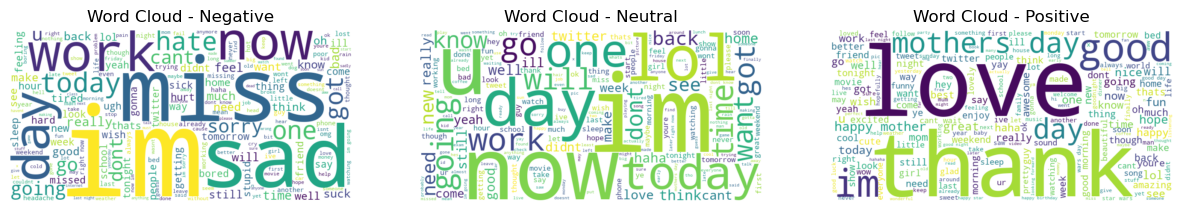

In [13]:
import numpy as np
from wordcloud import WordCloud

# Function to generate a word cloud for each sentiment category
def generate_wordclouds(df, sentiment_mapping):
    plt.figure(figsize=(15, 5))
    
    for i, (sentiment, label) in enumerate(sentiment_mapping.items()):
        text = " ".join(df[df["sentiment"] == label]["clean_text"])
        wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
        
        plt.subplot(1, 3, i + 1)
        plt.imshow(wordcloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word Cloud - {sentiment.capitalize()}")
    
    plt.show()


generate_wordclouds(df, {"negative": 0, "neutral": 1, "positive": 2})


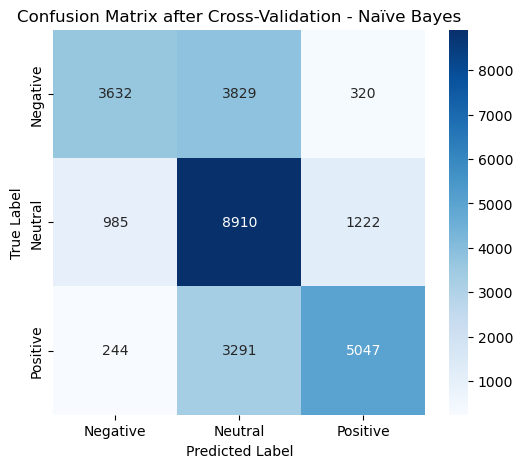

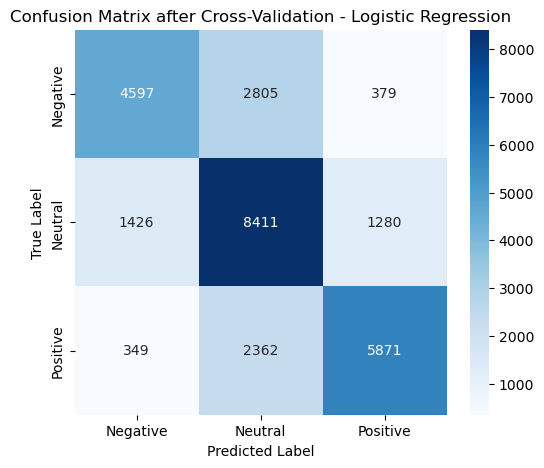

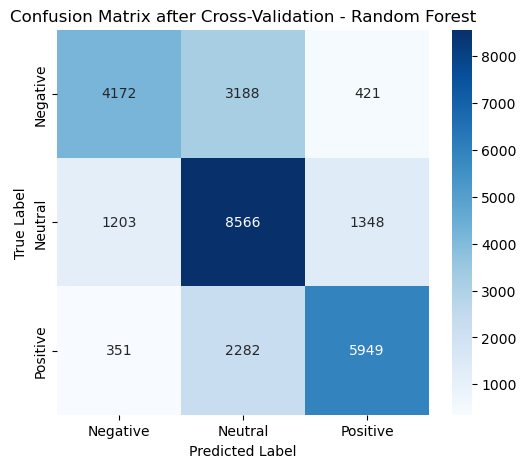

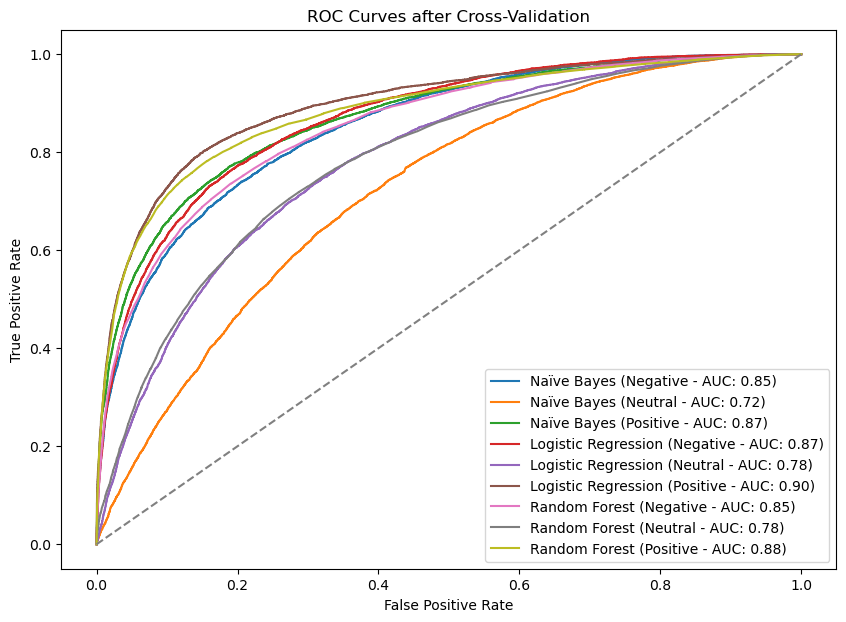

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Function to Plot Confusion Matrices after cross-validation
def plot_confusion_matrix_cv(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=["Negative", "Neutral", "Positive"], 
                yticklabels=["Negative", "Neutral", "Positive"])
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix after Cross-Validation - {model_name}")
    plt.show()

# Plot Confusion Matrices 
for model_name, predictions in cv_predictions.items():
    plot_confusion_matrix_cv(y, predictions, model_name)

# Function to Plot ROC Curves after cross-validation
def plot_roc_curves_cv(models, X, y):
    plt.figure(figsize=(10, 7))
    
    for name, model in models.items():
        if hasattr(model, "predict_proba"):
            y_scores = cross_val_predict(model, X, y, cv=5, method="predict_proba")
        else:
            y_scores = np.zeros((X.shape[0], len(set(y))))
            for i, class_label in enumerate(sorted(set(y))):
                y_scores[:, i] = cross_val_predict(model, X, y, cv=5) == class_label

        for i, sentiment in enumerate(["Negative", "Neutral", "Positive"]):
            fpr, tpr, _ = roc_curve((y == i).astype(int), y_scores[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, label=f"{name} ({sentiment} - AUC: {roc_auc:.2f})")

    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves after Cross-Validation")
    plt.legend()
    plt.show()

# Plot ROC Curves 
plot_roc_curves_cv(cv_models, X, y)
